# ОИАД. Лабораторная работа №3

##### Горелик Мария, 11b группа, КТС

## 1. Подготовка данных

### Чтение данных

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.shape

(1338, 7)

In [4]:
num_cols = ['age', 'bmi', 'children']
cat_cols = ['sex', 'smoker', 'region']
target = 'charges'

### Распредение числовых фичей и таргета

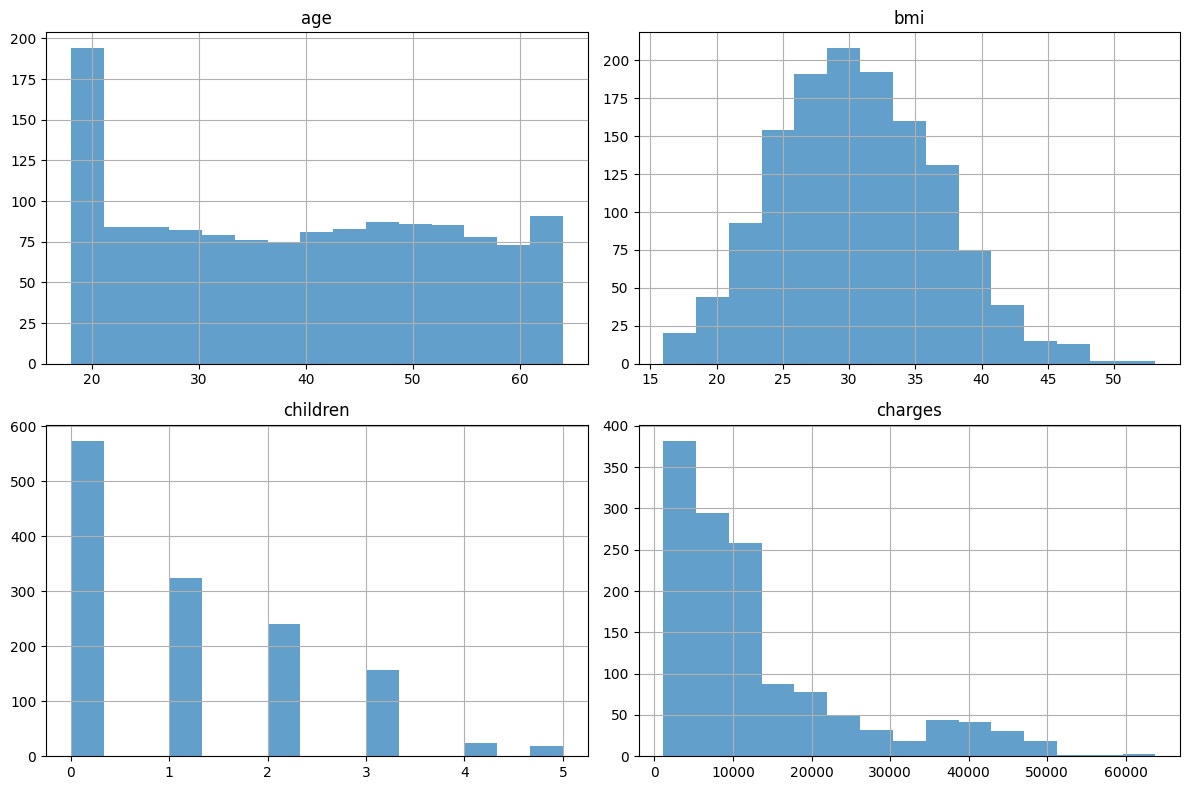

In [5]:
import matplotlib.pyplot as plt

df[num_cols + [target]].hist(
    bins=15,
    figsize=(12, 8),
    layout=(2, 2), 
    alpha=0.7
)
plt.tight_layout()
plt.show()

### Уникальные значения категориальных фичей

In [6]:
for col in cat_cols:
    unique_vals = df[col].unique()
    nunique_vals = df[col].nunique()
    print(f"{col}:")
    print(f"  Количество уникальных: {nunique_vals}")
    print(f"  Значения: {list(unique_vals)}")

sex:
  Количество уникальных: 2
  Значения: ['female', 'male']
smoker:
  Количество уникальных: 2
  Значения: ['yes', 'no']
region:
  Количество уникальных: 4
  Значения: ['southwest', 'southeast', 'northwest', 'northeast']


### 1. Проверка на наличие пропусков и выбросов

#### Пропуски

In [7]:
print('Количество пропусков в столбцах:')
print(df.isnull().sum())

Количество пропусков в столбцах:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


#### Выбросы (для числовых фичей)

Использовался метод межквартильного размаха (IQR)

In [8]:
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

In [9]:
print("Выбросы по методу IQR:")
for col in num_cols:
    outliers = detect_outliers_iqr(df[col])
    print(f"{col}: {len(outliers)} выбросов ({len(outliers)/len(df)*100:.2f}%)")

Выбросы по методу IQR:
age: 0 выбросов (0.00%)
bmi: 9 выбросов (0.67%)
children: 0 выбросов (0.00%)


Посмотрим на эти выбросы для bmi

In [10]:
print('Экстремальные значения bmi:')
detect_outliers_iqr(df['bmi'])

Экстремальные значения bmi:


116     49.06
286     48.07
401     47.52
543     47.41
847     50.38
860     47.60
1047    52.58
1088    47.74
1317    53.13
Name: bmi, dtype: float64

Распределение для bmi по своей природе является нормальным распределением. Посмотрим на выбросы для этого распределения другим подходом: с точки зрения выхода за 3 стандартных отклонения.

In [11]:
import numpy as np

def detect_outliers_zscore(column, threshold=3):
    z_scores = np.abs((column - column.mean()) / column.std())
    outliers = column[z_scores > threshold]
    return outliers

In [12]:
print('Значения bmi, выходящие за 3 стандартных отклонения:')
print(detect_outliers_zscore(df['bmi']))

Значения bmi, выходящие за 3 стандартных отклонения:
116     49.06
847     50.38
1047    52.58
1317    53.13
Name: bmi, dtype: float64


In [13]:
print('Верхняя граница для bmi по 3 std:')
upper_bound_bmi = df['bmi'].mean() + 3 * df['bmi'].std()
print(f"{upper_bound_bmi:.2f}")

Верхняя граница для bmi по 3 std:
48.96


Оставим эти значения. Возможно это действительно экстремально высокие значения bmi и их надо учитывать при обучении.

### Перевод категориальных признаков в числовые

Используем метод One-Hot Encoding (создавая на 1 меньше новых полей, чем уникальных значений в столбце)

In [14]:
df_encoded = pd.get_dummies(df, columns=cat_cols, dtype=int, drop_first=True)
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


### 3. Парные корреляции признаков

In [15]:
import seaborn as sns

def plot_correlation_heatmap(df, figsize=(12, 10), annot=True):
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    sns.heatmap(
        df.corr(),
        mask=mask,
        annot=annot,
        cmap='coolwarm',
        center=0,
        square=True,
        fmt='.2f',
        cbar_kws={'shrink': .8}
    )
    
    plt.title('Матрица парных корреляций', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

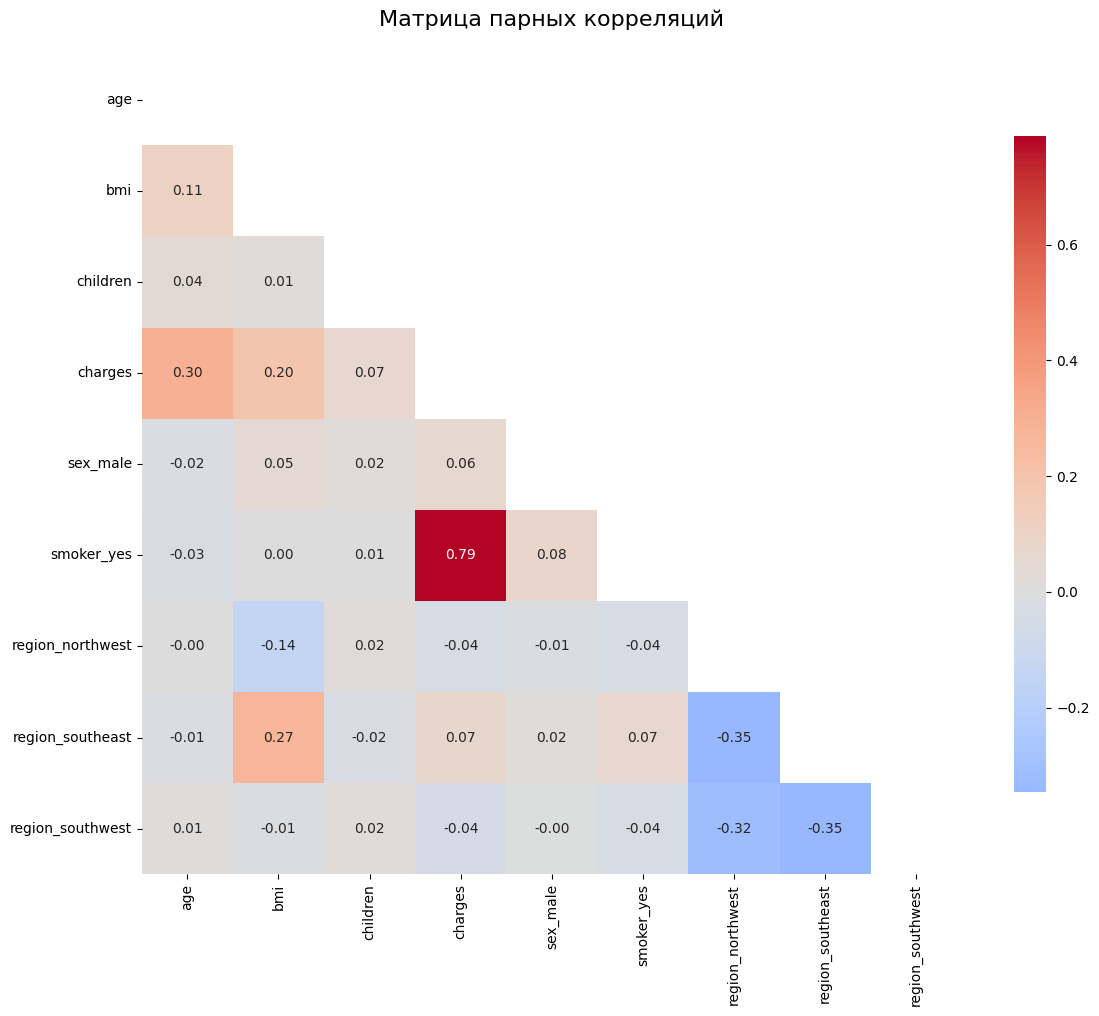

In [16]:
plot_correlation_heatmap(df_encoded)

## 2. Многомерная линейная регрессия

### Построить модель линейной регрессии и подобрать параметры:

#### 1. аналитически (реализовать самому)

In [17]:
X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
X_train.shape

(1070, 8)

In [61]:
X_test.shape

(268, 8)

In [18]:
print(X.columns)

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')


Аналитическое решение: w = (X^T * X)^(-1) * X^T * y

In [71]:
class AnalyticalLinearRegression:
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        """
        Аналитическое решение: w = (X^T * X)^(-1) * X^T * y
        Автоматически добавляет столбец единиц для intercept
        """
        X_np = X.values
        X_with_ones = np.column_stack([np.ones(X_np.shape[0]), X_np])
        y_np = y.values
        XTX = X_with_ones.T @ X_with_ones
        XTX_inv = np.linalg.inv(XTX)
        XTy = X_with_ones.T @ y_np
        self.weights = XTX_inv @ XTy
    
    def predict(self, X):
        """Предсказание: y_pred = X * w (с автоматическим добавлением единиц)"""
        if self.weights is None:
            raise ValueError("Модель не обучена. Сначала вызовите fit()")
        X_np = X.values
        X_with_ones = np.column_stack([np.ones(X_np.shape[0]), X_np])
        return X_with_ones @ self.weights
    
    def get_weights(self):
        return self.weights

In [72]:
analytical_regr = AnalyticalLinearRegression()
analytical_regr.fit(X_train, y_train)

#### Веса, полученные аналитически (включая смещение):

In [73]:
print(analytical_regr.get_weights())

[-1.19312191e+04  2.56975706e+02  3.37092552e+02  4.25278784e+02
 -1.85916916e+01  2.36511289e+04 -3.70677326e+02 -6.57864297e+02
 -8.09799354e+02]


#### 2. численно, с помощью методов градиентного спуска (реализовать самому)

1) За loss возьмем MSE
2) Веса первоначально инициализируем рандомными значениями
3) Для улучшения добавим нормализацию (стандартизацию)

In [96]:
class GradientDescentLinearRegression:
    def __init__(self, learning_rate=0.001, n_iter=100000, tolerance=1e-6):
        """
        learning_rate: скорость обучения
        n_iter: максимальное количество итераций
        tolerance: критерий остановки (изменение функции потерь)
        """
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.tolerance = tolerance
        self.weights = None
        self.loss_history = []
        self.mean_ = None
        self.std_ = None

    def _add_ones(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])

    def _normalize_fit(self, X):
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1
        return (X - self.mean_) / self.std_

    def _normalize_predict(self, X):
        return (X - self.mean_) / self.std_

    def _compute_loss(self, X, y):
        """MSE"""
        y_pred = X @ self.weights
        return np.mean((y_pred - y) ** 2)

    def _compute_gradient(self, X, y):
        y_pred = X @ self.weights
        error = y_pred - y
        gradient = (X.T @ error) / len(y)
        return gradient

    def fit(self, X, y, verbose=True):
        X_np = np.asarray(X)
        y_np = np.asarray(y)
        X_norm = self._normalize_fit(X_np)
        X_with_ones = self._add_ones(X_norm)
        self.weights = np.zeros(X_with_ones.shape[1])
        previous_loss = float('inf')
        for i in range(self.n_iter):
            gradient = self._compute_gradient(X_with_ones, y_np)
            self.weights -= self.learning_rate * gradient

            current_loss = self._compute_loss(X_with_ones, y_np)
            self.loss_history.append(current_loss)

            if abs(previous_loss - current_loss) < self.tolerance:
                if verbose:
                    print(f"Сходимость достигнута на итерации {i+1}")
                break

            previous_loss = current_loss

            if verbose and (i + 1) % 1000 == 0:
                print(f"Iteration {i+1}: Loss = {current_loss:.6f}")

        if verbose:
            print(f"Обучение завершено. Final loss: {current_loss:.6f}")

    def predict(self, X):
        if self.weights is None:
            raise ValueError("Модель не обучена. Сначала вызовите fit()")

        X_np = np.asarray(X)
        X_norm = self._normalize_predict(X_np)
        X_with_ones = self._add_ones(X_norm)
        return X_with_ones @ self.weights

    def get_weights(self):
        return self.weights

    def plot_loss_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_history)
        plt.title('История функции потерь')
        plt.xlabel('Итерация')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()


In [97]:
regr_grad_desc = GradientDescentLinearRegression()

In [98]:
regr_grad_desc.fit(X_train, y_train)

Iteration 1000: Loss = 76379767.818325
Iteration 2000: Loss = 42770069.591076
Iteration 3000: Loss = 38071448.231567
Iteration 4000: Loss = 37399439.549702
Iteration 5000: Loss = 37299425.041095
Iteration 6000: Loss = 37282994.623115
Iteration 7000: Loss = 37279579.637707
Iteration 8000: Loss = 37278547.527337
Iteration 9000: Loss = 37278117.507936
Iteration 10000: Loss = 37277908.094693
Iteration 11000: Loss = 37277800.419355
Iteration 12000: Loss = 37277744.127592
Iteration 13000: Loss = 37277714.554058
Iteration 14000: Loss = 37277698.994847
Iteration 15000: Loss = 37277690.805356
Iteration 16000: Loss = 37277686.494325
Iteration 17000: Loss = 37277684.224868
Iteration 18000: Loss = 37277683.030143
Iteration 19000: Loss = 37277682.401195
Iteration 20000: Loss = 37277682.070092
Iteration 21000: Loss = 37277681.895787
Iteration 22000: Loss = 37277681.804026
Iteration 23000: Loss = 37277681.755719
Iteration 24000: Loss = 37277681.730289
Iteration 25000: Loss = 37277681.716901
Iteration

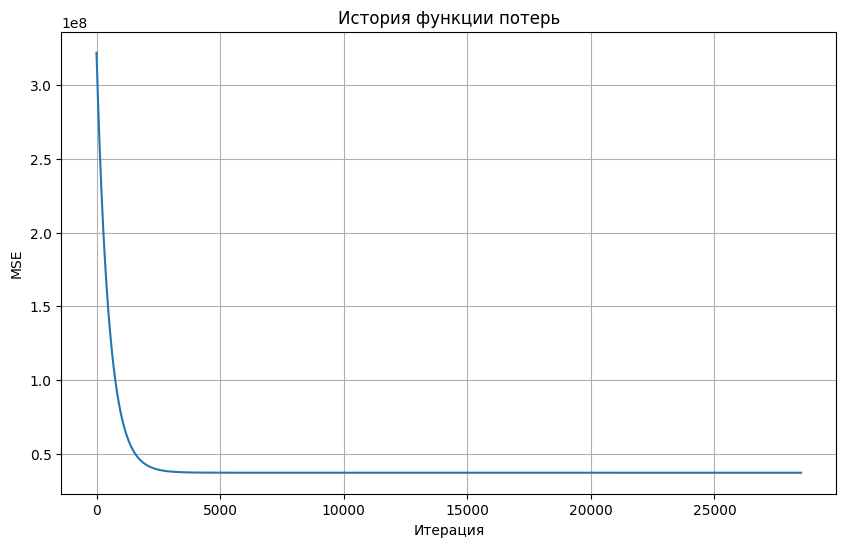

In [99]:
regr_grad_desc.plot_loss_history()

#### Веса, полученные с помощью градиентного спуска:

In [100]:
regr_grad_desc.get_weights()

array([ 1.33460897e+04,  3.61497611e+03,  2.03621828e+03,  5.16889934e+02,
       -9.29253829e+00,  9.55848182e+03, -1.58102965e+02, -2.90114694e+02,
       -3.49071158e+02])

## 3. Добавление регуляризации

### Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:

Будем использовать L2 регуляризацию

### 1. аналитически

Аналитическое решение: w = (X^T * X + lambda * I)^(-1) * X^T * y

In [80]:
class AnalyticalRidgeRegression:
    def __init__(self, lambda_=1.0):
        self.lambda_ = lambda_
        self.weights = None

    def fit(self, X, y):
        X_np = np.asarray(X)
        y_np = np.asarray(y)
        X_with_ones = np.column_stack([np.ones(X_np.shape[0]), X_np])
        n_features = X_with_ones.shape[1]
        L2 = np.eye(n_features)
        L2[0, 0] = 0  
        XTX = X_with_ones.T @ X_with_ones
        XTX_reg = XTX + self.lambda_ * L2
        XTy = X_with_ones.T @ y_np
        self.weights = np.linalg.inv(XTX_reg) @ XTy

    def predict(self, X):
        if self.weights is None:
            raise ValueError("Сначала вызовите fit()")
        X_np = np.asarray(X)
        X_with_ones = np.column_stack([np.ones(X_np.shape[0]), X_np])
        return X_with_ones @ self.weights

    def get_weights(self):
        return self.weights

In [81]:
analytical_ridge = AnalyticalRidgeRegression()

In [82]:
analytical_ridge.fit(X_train, y_train)

In [83]:
analytical_ridge.get_weights()

array([-1.18998928e+04,  2.56782216e+02,  3.36877819e+02,  4.25798686e+02,
       -1.06683261e+01,  2.35150895e+04, -3.66407914e+02, -6.44135484e+02,
       -8.03575305e+02])

### 2. численно

In [101]:
class GradientDescentRidgeRegression:
    def __init__(self, learning_rate=0.001, lambda_=1.0, n_iter=100000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.n_iter = n_iter
        self.tolerance = tolerance

        self.weights = None
        self.loss_history = []
        self.mean_ = None
        self.std_ = None

    def _add_ones(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])

    def _normalize_fit(self, X):
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1
        return (X - self.mean_) / self.std_

    def _normalize_predict(self, X):
        return (X - self.mean_) / self.std_

    def _compute_loss(self, X, y):
        y_pred = X @ self.weights
        mse = np.mean((y_pred - y) ** 2)
        l2_penalty = self.lambda_ * np.sum(self.weights[1:] ** 2)

        return mse + l2_penalty

    def _compute_gradient(self, X, y):
        y_pred = X @ self.weights
        error = y_pred - y
        gradient = (X.T @ error) / len(y)
        l2_grad = np.copy(self.weights)
        l2_grad[0] = 0
        gradient += self.lambda_ * l2_grad
        return gradient

    def fit(self, X, y, verbose=True):
        X_np = np.asarray(X)
        y_np = np.asarray(y)
        X_norm = self._normalize_fit(X_np)
        X_with_ones = self._add_ones(X_norm)
        self.weights = np.zeros(X_with_ones.shape[1])
        previous_loss = float('inf')
        for i in range(self.n_iter):
            gradient = self._compute_gradient(X_with_ones, y_np)
            self.weights -= self.learning_rate * gradient
            current_loss = self._compute_loss(X_with_ones, y_np)
            self.loss_history.append(current_loss)
            if abs(previous_loss - current_loss) < self.tolerance:
                if verbose:
                    print(f"Сходимость достигнута на итерации {i+1}")
                break

            previous_loss = current_loss

            if verbose and (i + 1) % 1000 == 0:
                print(f"Iteration {i+1}: Loss = {current_loss:.6f}")

        if verbose:
            print(f"Обучение завершено. Final loss: {current_loss:.6f}")

    def predict(self, X):
        if self.weights is None:
            raise ValueError("Сначала вызовите fit()")
        X_np = np.asarray(X)
        X_norm = self._normalize_predict(X_np)
        X_with_ones = self._add_ones(X_norm)
        return X_with_ones @ self.weights

    def get_weights(self):
        return self.weights

    def plot_loss_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_history)
        plt.title('История функции потерь')
        plt.xlabel('Итерация')
        plt.ylabel('MSE + L2 penalty')
        plt.grid(True)
        plt.show()

In [102]:
gradient_ridge = GradientDescentRidgeRegression()

In [103]:
gradient_ridge.fit(X_train, y_train)

Iteration 1000: Loss = 116134661.134444
Iteration 2000: Loss = 94336762.159014
Iteration 3000: Loss = 91501907.370217
Iteration 4000: Loss = 91120834.674211
Iteration 5000: Loss = 91069358.726161
Iteration 6000: Loss = 91062400.152392
Iteration 7000: Loss = 91061459.376770
Iteration 8000: Loss = 91061332.184648
Iteration 9000: Loss = 91061314.988310
Iteration 10000: Loss = 91061312.663368
Iteration 11000: Loss = 91061312.349036
Iteration 12000: Loss = 91061312.306539
Iteration 13000: Loss = 91061312.300793
Сходимость достигнута на итерации 13287
Обучение завершено. Final loss: 91061312.300401


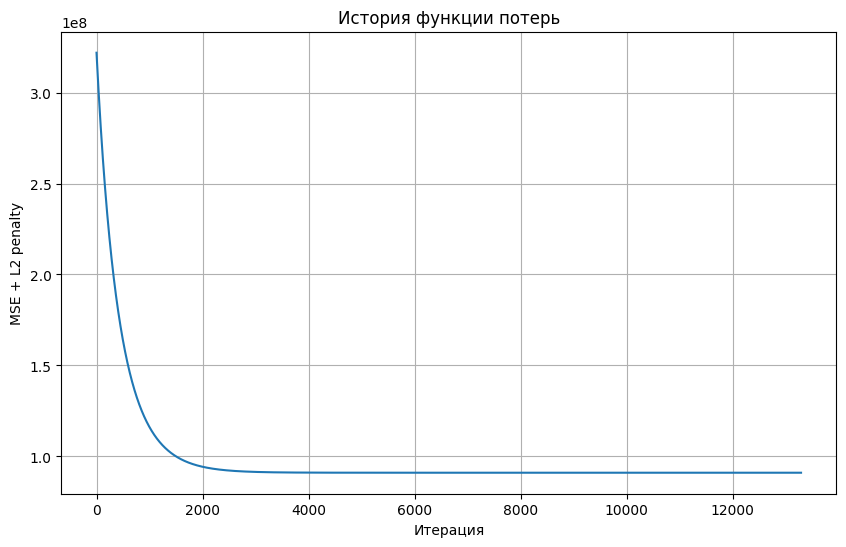

In [104]:
gradient_ridge.plot_loss_history()

In [105]:
gradient_ridge.get_weights()

array([13346.06724602,  1745.03089943,  1069.38404041,   349.78327863,
         170.46464335,  4717.35838762,   -90.93596795,   129.65033374,
        -146.42154722])

## 4. Оценка обобщающей способности

Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:

1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

#### Константная модель

In [89]:
constant_pred = np.full_like(y_test, y_train.mean())

In [90]:
from sklearn.metrics import mean_squared_error

#### Ошибка на константной модели

In [91]:
mean_squared_error(y_test, constant_pred)

155391443.68461317

#### Ошибка на аналитической модели без регуляризации

In [106]:
mean_squared_error(y_test, analytical_regr.predict(X_test))

33596915.8513615

#### Ошибка на аналитической модели с L2 регуляризацией

In [93]:
mean_squared_error(y_test, analytical_ridge.predict(X_test))

33645037.09177913

#### Ошибка на модели с градиентным спуском

In [107]:
mean_squared_error(y_test, regr_grad_desc.predict(X_test))

33596945.25504431

#### Ошибка на модели с градиентным спуском с L2 регуляризацией

In [109]:
mean_squared_error(y_test, gradient_ridge.predict(X_test))

66295954.36650565